<h1>
<center>
Email Spam Detector using MLR, SVM, NN
</center>
</h1>
<center>
CS5262 Foundations of Machine Learning
</center>
<center>
Yizhou Guo
</center>

## Load the data and plot some feature combinations:
- money AND send
- special_char divided by total_word AND un_recog divided by total_word
- un_recog divided by total_word AND re_recog divided by total_word

In [2]:
import pandas as pd

# Load the data
data_path = 'data/enron1_data.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataframe and the column names
# data.head(), data.columns.tolist()

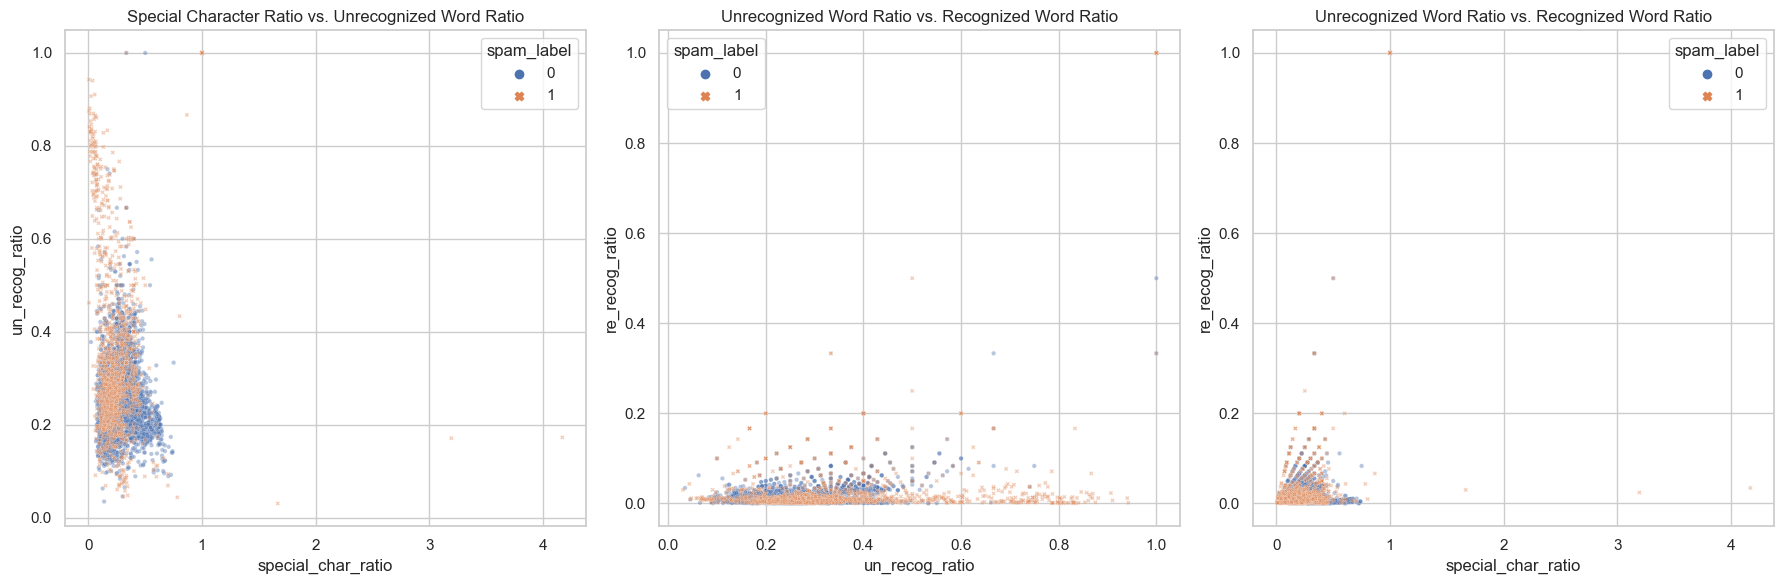

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: "money" AND "send"
# sns.scatterplot(ax=axes[0], data=data, x='money', y='send', hue='label', style='label', palette='viridis')
# axes[0].set_title('Money vs. Send')

# Plot 2: "special_char"/"total_word" AND "un_recog"/"total_word"
data['special_char_ratio'] = data['special_char'] / data['total_word']
data['un_recog_ratio'] = data['un_recog'] / data['total_word']
sns.scatterplot(ax=axes[0], data=data, x='special_char_ratio', y='un_recog_ratio', hue='spam_label', style='spam_label',s=10,alpha=0.4)
axes[0].set_title('Special Character Ratio vs. Unrecognized Word Ratio')

# Plot 3: "un_recog"/"total_word" AND "re_recog"/"total_word"
data['re_recog_ratio'] = data['re_recog'] / data['total_word']
sns.scatterplot(ax=axes[1], data=data, x='un_recog_ratio', y='re_recog_ratio', hue='spam_label', style='spam_label',s=10,alpha=0.4)
axes[1].set_title('Unrecognized Word Ratio vs. Recognized Word Ratio')

# Plot 3: "un_recog"/"total_word" AND "re_recog"/"total_word"
sns.scatterplot(ax=axes[2], data=data, x='special_char_ratio', y='re_recog_ratio', hue='spam_label', style='spam_label',s=10,alpha=0.4)
axes[2].set_title('Unrecognized Word Ratio vs. Recognized Word Ratio')

plt.tight_layout()
plt.show()

## Use 3D plotting to plot the three special ratios we want to know

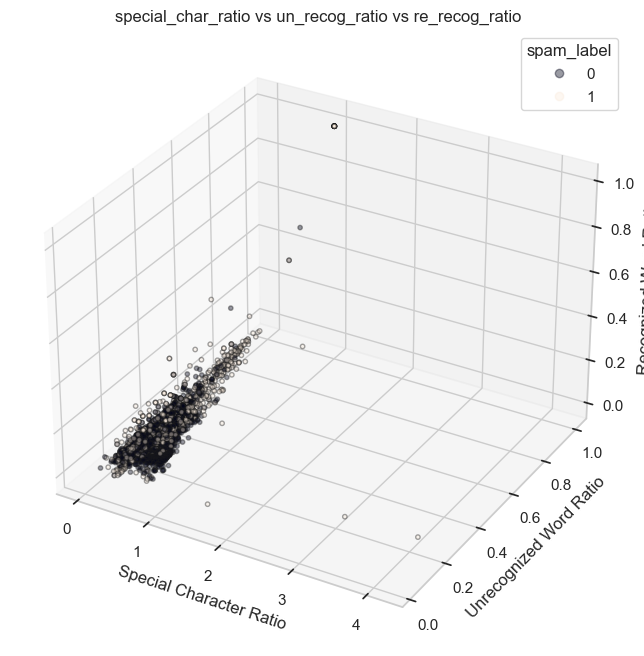

In [5]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Data for 3D plot
x = data['special_char_ratio']
y = data['un_recog_ratio']
z = data['re_recog_ratio']

# Plot
scatter = ax.scatter(x, y, z, c=data['spam_label'], marker='o', edgecolor='k', s=10, alpha=0.4)

# Legend and labels
ax.legend(*scatter.legend_elements(), title="spam_label")
ax.set_xlabel('Special Character Ratio')
ax.set_ylabel('Unrecognized Word Ratio')
ax.set_zlabel('Recognized Word Ratio')

# Title
ax.set_title('special_char_ratio vs un_recog_ratio vs re_recog_ratio')

plt.show()

## Analyze the data and select features
- For both spam and ham, sum the word counts for each word.
- Then, divide the count by total_words. 
- Find 10 words that has the most apperance rate difference (5 largest positive and 5 largest negative).
- Repeat the step above but this time use ratio (skip the word if sum from either spam or ham set is 0). 

In [6]:
# Separate the dataset into spam and ham
spam_data = data[data['spam_label'] == 1]
ham_data = data[data['spam_label'] == 0]

# Calculate sum of word counts for each word (excluding control columns like total_word, un_recog, etc.)
word_columns = [col for col in data.columns if col not in ['un_recog', 're_recog', 'special_char', 'total_word', 'spam_label']]

# Sum of word counts
spam_counts = spam_data[word_columns].sum()
ham_counts = ham_data[word_columns].sum()

# Total words for spam and ham
total_words_spam = spam_data['total_word'].sum()
total_words_ham = ham_data['total_word'].sum()

# Calculate appearance rate
spam_rates = spam_counts / total_words_spam
ham_rates = ham_counts / total_words_ham

# Compute difference in appearance rates
rate_differences = (spam_rates - ham_rates)

# Find 10 words with the largest difference in appearance rates
top_5_pos_diff = rate_differences.nlargest(5)
top_5_neg_diff = rate_differences.nsmallest(5)

# Get the corresponding rates for these words
words = list(top_5_pos_diff.index) + list(top_5_neg_diff.index)
appearance_rates = pd.DataFrame({
    'Word': words,
    'Spam Rate': spam_rates[words],
    'Ham Rate': ham_rates[words]
})

appearance_rates

,Word,Spam Rate,Ham Rate
of,of,0.012736,0.006865
and,and,0.013931,0.009567
a,a,0.010817,0.007287
in,in,0.008849,0.005526
your,your,0.005558,0.002527
to,to,0.014596,0.018346
on,on,0.003593,0.007315
deal,deal,0.000110,0.003372
i,i,0.003238,0.006337
meter,meter,0.000000,0.002973


In [7]:
# Filter out words where either spam or ham counts are less than 5
filtered_spam_counts = spam_counts[spam_counts >= 5]
filtered_ham_counts = ham_counts[ham_counts >= 5]

# Ensure we're considering words that appear in both filtered sets
common_words = filtered_spam_counts.index.intersection(filtered_ham_counts.index)

# Calculate ratios where both counts are above the threshold
spam_ham_ratios = (filtered_spam_counts.loc[common_words] / total_words_spam) / (filtered_ham_counts.loc[common_words] / total_words_ham)

# Find 5 largest and 5 smallest ratios
top_5_largest_ratios = spam_ham_ratios.nlargest(5)
top_5_smallest_ratios = spam_ham_ratios.nsmallest(5)

# Combine results
words_ratios = list(top_5_largest_ratios.index) + list(top_5_smallest_ratios.index)
ratios_data = pd.DataFrame({
    'Word': words_ratios,
    'Spam Rate': spam_rates[words_ratios],
    'Ham Rate': ham_rates[words_ratios],
    'Ratio': spam_ham_ratios[words_ratios]
})

ratios_data

,Word,Spam Rate,Ham Rate,Ratio
size,size,0.000890,0.000017,52.546798
health,health,0.000308,0.000006,50.966960
style,style,0.000363,0.000008,42.930390
investment,investment,0.000820,0.000023,35.681933
publication,publication,0.000212,0.000006,35.099887
pm,pm,0.000049,0.002811,0.017578
deal,deal,0.000110,0.003372,0.032756
volume,volume,0.000067,0.001060,0.063049
gathering,gathering,0.000015,0.000221,0.065686
transport,transport,0.000032,0.000464,0.068868


## Multiple linear regression


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
import random

# Prepare data for the four combinations
# X1 = data[list(top_5_pos_diff)]
# X2 = data[list(top_5_neg_diff)]
X1 = data[words]
X2 = data[words+['special_char_ratio', 'un_recog_ratio', 're_recog_ratio']]
X3 = data[words_ratios]
X4 = data[words_ratios+['special_char_ratio', 'un_recog_ratio', 're_recog_ratio']]
X5 = data[words+words_ratios+['special_char_ratio', 'un_recog_ratio', 're_recog_ratio']]
y1 = data['spam_label']
y2 = data['spam_label']
y3 = data['spam_label']
y4 = data['spam_label']
y5 = data['spam_label']

# rs = random.randint(1,100)
rs = 63
# Splitting the data into train and test sets for each combination
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=rs, stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=rs, stratify=y2)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=rs, stratify=y3)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=rs, stratify=y4)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=rs, stratify=y5)

# Initialize and train linear regression models
model1 = LinearRegression().fit(X1_train, y1_train)
model2 = LinearRegression().fit(X2_train, y2_train)
model3 = LinearRegression().fit(X3_train, y3_train)
model4 = LinearRegression().fit(X4_train, y4_train)
model5 = LinearRegression().fit(X5_train, y5_train)

# Predictions
y_pred1 = model1.predict(X1_test)
y_pred2 = model2.predict(X2_test)
y_pred3 = model3.predict(X3_test)
y_pred4 = model4.predict(X4_test)
y_pred5 = model5.predict(X5_test)

def compute_accuracy(y_true, y_pred):
    y_pred_label = [1 if pred > 0.5 else 0 for pred in y_pred]
    return accuracy_score(y_true, y_pred_label)

accuracy1 = compute_accuracy(y1_test, y_pred1)
accuracy2 = compute_accuracy(y2_test, y_pred2)
accuracy3 = compute_accuracy(y3_test, y_pred3)
accuracy4 = compute_accuracy(y4_test, y_pred4)
accuracy5 = compute_accuracy(y5_test, y_pred5)

print(accuracy1, accuracy2, accuracy3, accuracy4, accuracy5)

0.7344961240310077 0.7722868217054264 0.7306201550387597 0.7645348837209303 0.7790697674418605


### Confusion matrix analysis

In [9]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y5_test, [1 if pred > 0.5 else 0 for pred in y_pred5])
tn, fp, fn, tp = conf_matrix.ravel()
tn, fp, fn, tp

(711, 24, 204, 93)

## Support Vector Machine

In [10]:
from sklearn.svm import SVC


# Initialize and train Support Vector Machine (SVM) model
svm_model = SVC(kernel='linear').fit(X5_train, y5_train)
# svm_model = SVC(kernel='poly').fit(X5_train, y5_train)
# svm_model = SVC(kernel='rbf').fit(X5_train, y5_train)

# Predictions
y_pred_svm = svm_model.predict(X5_test)

# Evaluation
accuracy_svm = accuracy_score(y5_test, y_pred_svm)

print(accuracy_svm)

0.7868217054263565


### Confusion matrix analysis

from sklearn.metrics import confusion_matrix

# Generate confusion matrix for SVM predictions on ['special_char_ratio', 'un_recog_ratio', 're_recog_ratio']
conf_matrix = confusion_matrix(y5_test, y_pred_svm)

# Extract true positives (TP), false negatives (FN), true negatives (TN), and false positives (FP)
tp = conf_matrix[1, 1]  # True Positive (Spam correctly identified as Spam)
fn = conf_matrix[1, 0]  # False Negative (Spam incorrectly identified as Non-Spam)
tn = conf_matrix[0, 0]  # True Negative (Non-Spam correctly identified as Non-Spam)
fp = conf_matrix[0, 1]  # False Positive (Non-Spam incorrectly identified as Spam)

tn, fp, fn, tp

## Neural Networks

In [12]:

X = data[words+words_ratios+['special_char_ratio', 'un_recog_ratio', 're_recog_ratio']]
y = data['spam_label']

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=rs)

# Display the shapes of the splits to confirm correct splitting
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4125, 23), (1032, 23), (4125,), (1032,))

### ANN

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, SimpleRNN, Embedding

model_ann = Sequential([
    Dense(512, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_ann.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
test_loss, test_accuracy = model_ann.evaluate(X_test, y_test)
conf_matrix = confusion_matrix(y_test,[1 if pred > 0.5 else 0 for pred in model_ann.predict(X_test)] )
# Extract true positives (TP), false negatives (FN), true negatives (TN), and false positives (FP)
tp = conf_matrix[1, 1]  # True Positive (Spam correctly identified as Spam)
fn = conf_matrix[1, 0]  # False Negative (Spam incorrectly identified as Non-Spam)
tn = conf_matrix[0, 0]  # True Negative (Non-Spam correctly identified as Non-Spam)
fp = conf_matrix[0, 1]  # False Positive (Non-Spam incorrectly identified as Spam)

test_loss, test_accuracy, tn, fp, fn, tp

33/33 [==============================] - 0s 719us/step


(0.30359482765197754, 0.8439922332763672, 678, 57, 104, 193)

In [55]:
conf_matrix = confusion_matrix(y_test,[1 if pred > 0.6 else 0 for pred in model_ann.predict(X_test)] )
# Extract true positives (TP), false negatives (FN), true negatives (TN), and false positives (FP)
tp = conf_matrix[1, 1]  # True Positive (Spam correctly identified as Spam)
fn = conf_matrix[1, 0]  # False Negative (Spam incorrectly identified as Non-Spam)
tn = conf_matrix[0, 0]  # True Negative (Non-Spam correctly identified as Non-Spam)
fp = conf_matrix[0, 1]  # False Positive (Non-Spam incorrectly identified as Spam)

tn, fp, fn, tp

33/33 [==============================] - 0s 750us/step


(698, 37, 122, 175)

### CNN

In [49]:
model_cnn = Sequential([
    Conv1D(512, 5, activation='relu', input_shape=(X_train.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
test_loss, test_accuracy = model_cnn.evaluate(X_test, y_test)
conf_matrix = confusion_matrix(y_test,[1 if pred > 0.5 else 0 for pred in model_cnn.predict(X_test)] )
# Extract true positives (TP), false negatives (FN), true negatives (TN), and false positives (FP)
tp = conf_matrix[1, 1]  # True Positive (Spam correctly identified as Spam)
fn = conf_matrix[1, 0]  # False Negative (Spam incorrectly identified as Non-Spam)
tn = conf_matrix[0, 0]  # True Negative (Non-Spam correctly identified as Non-Spam)
fp = conf_matrix[0, 1]  # False Positive (Non-Spam incorrectly identified as Spam)

test_loss, test_accuracy, tn, fp, fn, tp

33/33 [==============================] - 0s 812us/step


(0.42785775661468506, 0.7974806427955627, 634, 101, 108, 189)

In [56]:
conf_matrix = confusion_matrix(y_test,[1 if pred > 0.6 else 0 for pred in model_cnn.predict(X_test)] )
# Extract true positives (TP), false negatives (FN), true negatives (TN), and false positives (FP)
tp = conf_matrix[1, 1]  # True Positive (Spam correctly identified as Spam)
fn = conf_matrix[1, 0]  # False Negative (Spam incorrectly identified as Non-Spam)
tn = conf_matrix[0, 0]  # True Negative (Non-Spam correctly identified as Non-Spam)
fp = conf_matrix[0, 1]  # False Positive (Non-Spam incorrectly identified as Spam)

tn, fp, fn, tp

33/33 [==============================] - 0s 844us/step


(690, 45, 162, 135)

In [70]:
test_data_path = 'data/test_data.csv'
test_data = pd.read_csv(test_data_path)

test_data['special_char_ratio'] = test_data['special_char'] / test_data['total_word']
test_data['un_recog_ratio'] = test_data['un_recog'] / test_data['total_word']

test_data['re_recog_ratio'] = test_data['re_recog'] / test_data['total_word']

X_real_test = test_data[words+words_ratios+['special_char_ratio', 'un_recog_ratio', 're_recog_ratio']]
real_predict = model_ann.predict(X_real_test)
actual = ['S','S','S','S','H','H','H','H']

for i in range(len(real_predict)):
    print(f"{i+1}.txt: score: {real_predict[i][0]:.6f}, prediction(0.5): {'S' if real_predict[i][0] > 0.5 else 'H'}, prediction(0.6): {'S' if real_predict[i][0] > 0.6 else 'H'}, actual: {actual[i]}")


1/1 [==============================] - 0s 12ms/step
1.txt: score: 0.493067, prediction(0.5): H, prediction(0.6): H, actual: S
2.txt: score: 0.633545, prediction(0.5): S, prediction(0.6): S, actual: S
3.txt: score: 0.970924, prediction(0.5): S, prediction(0.6): S, actual: S
4.txt: score: 0.600601, prediction(0.5): S, prediction(0.6): S, actual: S
5.txt: score: 0.001690, prediction(0.5): H, prediction(0.6): H, actual: H
6.txt: score: 0.255883, prediction(0.5): H, prediction(0.6): H, actual: H
7.txt: score: 0.197241, prediction(0.5): H, prediction(0.6): H, actual: H
8.txt: score: 0.138819, prediction(0.5): H, prediction(0.6): H, actual: H
